In [1]:
import os
import math
import random
import shutil
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BASE_DIR = 'lego/star-wars-images/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [3]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

In [4]:
# get the preprocessing function of this model // The same funtion works for ResNet
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'lego/star-wars-images/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'lego/star-wars-images/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'lego/star-wars-images/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


### 1: Only changing the very last layer of the net

#### Random initialization of the weights

In [5]:
# Load the model from the pretrained ones
vgg16_base_blank = tf.keras.applications.vgg16.VGG16()
#vgg16_model.summary()

# Convert to Sequential model, omit the last layer

# // This works with VGG16 because the structure is linear, if not, then other techniques have to be applied
model_vgg16 = keras.models.Sequential()
for layer in vgg16_base_blank.layers[0:-1]:
    model_vgg16.add(layer)

# Set trainable=False for all layers
# //we don't want to train them again so we freeze them
for layer in model_vgg16.layers:
    layer.trainable = False
# Add a last classification layer for our use case with 5 classes
model_vgg16.add(layers.Dense(5))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-28 13:35:02.219505: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-28 13:35:02.219815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Initiatin with pre-trained weights

In [6]:
# Convert to Sequential model, omit the last layer
# Load the model from the pretrained ones
vgg16_base_trained = tf.keras.applications.vgg16.VGG16(weights='imagenet')

# // This works with VGG16 because the structure is linear, if not, then other techniques have to be applied
model_vgg16_2 = keras.models.Sequential()
for layer in vgg16_base_trained.layers[0:-1]:
    model_vgg16_2.add(layer)

# Set trainable=False for all layers
# //we don't want to train them again so we freeze them
for layer in model_vgg16_2.layers:
    layer.trainable = False
# Add a last classification layer for our use case with 5 classes
model_vgg16_2.add(layers.Dense(5))

In [7]:
model_vgg16.compile(optimizer=optim, loss=loss, metrics=metrics)
model_vgg16_2.compile(optimizer=optim, loss=loss, metrics=metrics)

# Fit the model

epochs = 30
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,verbose=2)
#early_stopping2 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,verbose=2)

# Train the VGG model
print('*************TRAINING THE VGG16 MODEL*************')
history_vgg16 = model_vgg16.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)
print('*************TRAINING THE VGG16 MODEL PRE-TRAINED*************')
history_vgg16_2 = model_vgg16_2.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)


*************TRAINING THE VGG16 MODEL*************
Epoch 1/30


2022-10-28 13:35:05.881638: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-28 13:35:06.119738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 13:35:07.252818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 2s - loss: 2.2679 - accuracy: 0.4054 - val_loss: 0.8104 - val_accuracy: 0.7500 - 2s/epoch - 175ms/step
Epoch 2/30
10/10 - 1s - loss: 0.3103 - accuracy: 0.8919 - val_loss: 0.3924 - val_accuracy: 0.8750 - 1s/epoch - 110ms/step
Epoch 3/30
10/10 - 1s - loss: 0.0523 - accuracy: 0.9730 - val_loss: 0.1553 - val_accuracy: 0.9375 - 1s/epoch - 110ms/step
Epoch 4/30
10/10 - 1s - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0894 - val_accuracy: 0.9375 - 1s/epoch - 109ms/step
Epoch 5/30
10/10 - 1s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.1061 - val_accuracy: 0.9375 - 1s/epoch - 110ms/step
Epoch 6/30
10/10 - 1s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1272 - val_accuracy: 0.9375 - 1s/epoch - 111ms/step
Epoch 7/30
10/10 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1425 - val_accuracy: 0.9375 - 1s/epoch - 109ms/step
Epoch 8/30
10/10 - 1s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1534 - val_accuracy: 0.9375 - 1s/epoch - 109ms/step
Epoch 9/30
10/10 - 1s - loss: 0.002

2022-10-28 13:35:16.740834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 13:35:17.670710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 2s - loss: 1.7900 - accuracy: 0.3784 - val_loss: 1.0476 - val_accuracy: 0.7500 - 2s/epoch - 155ms/step
Epoch 2/30
10/10 - 1s - loss: 0.3338 - accuracy: 0.8378 - val_loss: 0.8519 - val_accuracy: 0.8750 - 1s/epoch - 109ms/step
Epoch 3/30
10/10 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.1320 - val_accuracy: 0.9375 - 1s/epoch - 109ms/step
Epoch 4/30
10/10 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 1.0000 - 1s/epoch - 109ms/step
Epoch 5/30
10/10 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0568 - val_accuracy: 1.0000 - 1s/epoch - 109ms/step
Epoch 6/30
10/10 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 1.0000 - 1s/epoch - 109ms/step
Epoch 7/30
10/10 - 1s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0701 - val_accuracy: 0.9375 - 1s/epoch - 110ms/step
Epoch 8/30
10/10 - 1s - loss: 8.9195e-04 - accuracy: 1.0000 - val_loss: 0.0782 - val_accuracy: 0.9375 - 1s/epoch - 109ms/step
Epoch 9/30
10/10 - 1s - loss: 7

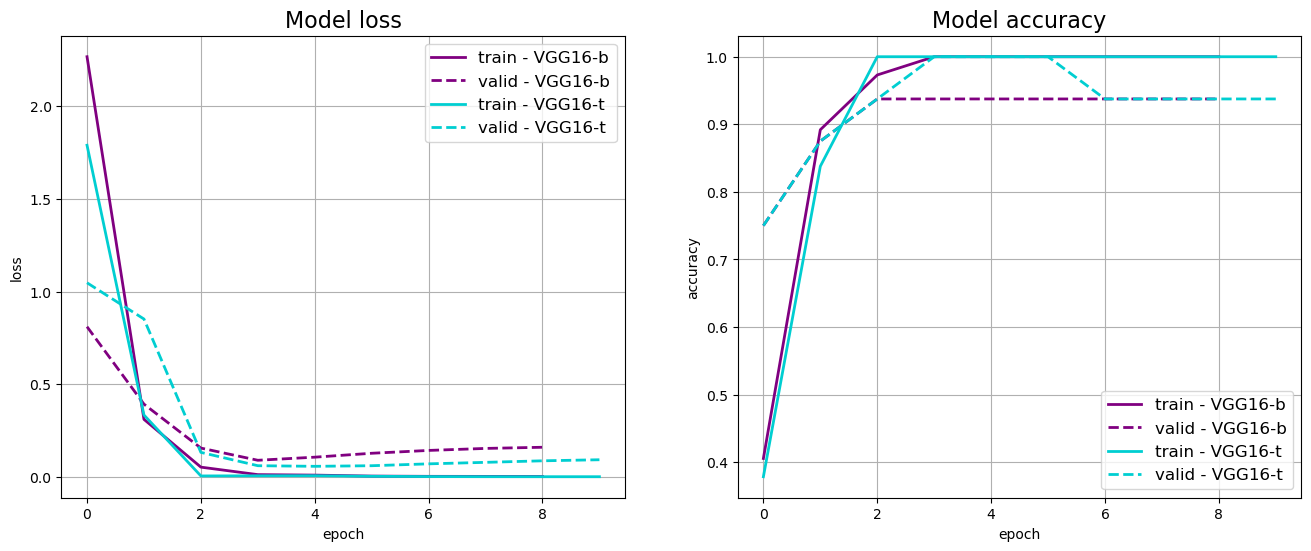

In [8]:
# Plots for loss and acc
from turtle import color


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='train - VGG16-b', color = 'purple', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16.history['val_loss'], label='valid - VGG16-b', color = 'purple', linestyle='--',
        linewidth=2)
plt.plot(history_vgg16_2.history['loss'], label='train - VGG16-t', color = 'darkturquoise', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16_2.history['val_loss'], label='valid - VGG16-t', color = 'darkturquoise', linestyle='--',
        linewidth=2)
plt.title('Model loss', fontdict={'size': 16})  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='train - VGG16-b', color = 'purple', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16.history['val_accuracy'], label='valid - VGG16-b', color = 'purple', linestyle='--',
        linewidth=2)
plt.plot(history_vgg16_2.history['accuracy'], label='train - VGG16-t', color = 'darkturquoise', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16_2.history['val_accuracy'], label='valid - VGG16-t', color = 'darkturquoise', linestyle='--',
        linewidth=2)
plt.title('Model accuracy',fontdict={'size': 16})  
plt.ylabel('accuracy')  
plt.xlabel('epoch') 
plt.grid()
plt.legend(fontsize=12)

In [9]:
# Evaluate the models
print("Evaluation of the VGG16 with random weights")
model_vgg16.evaluate(test_batches, verbose=2)
print("Evaluation of the VGG16 with pre-trained weights")
model_vgg16_2.evaluate(test_batches, verbose=2)


Evaluation of the VGG16 with random weights
3/3 - 0s - loss: 0.5355 - accuracy: 0.9000 - 266ms/epoch - 89ms/step
Evaluation of the VGG16 with pre-trained weights
3/3 - 0s - loss: 0.1522 - accuracy: 0.9000 - 249ms/epoch - 83ms/step


[0.15218494832515717, 0.9000000357627869]

### 2: Using "include top = False" which removes the 3 fully-connected layers at the top of the network

#### Random initialization of weights

In [10]:
model_vgg16_3 = keras.models.Sequential()
model_vgg16_3.add(tf.keras.applications.vgg16.VGG16(include_top=False, pooling='max')) # We add the pooling to make the dimension comparable
model_vgg16_3.add(layers.Dense(5))
model_vgg16_3.layers[0].trainable = False
#model_vgg16_3.summary()

#### Using the pre-trained weights

In [11]:
model_vgg16_4 = keras.models.Sequential()
model_vgg16_4.add(tf.keras.applications.vgg16.VGG16(weights='imagenet' ,include_top=False, pooling='max')) # We add the pooling to make the dimension comparable
model_vgg16_4.add(layers.Dense(5))
model_vgg16_4.layers[0].trainable = False
#model_vgg16_3.summary()

In [12]:
# Compile the models
model_vgg16_3.compile(optimizer=optim, loss=loss, metrics=metrics)
model_vgg16_4.compile(optimizer=optim, loss=loss, metrics=metrics)

# Fit the model

epochs = 30
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,verbose=2)
#early_stopping2 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,verbose=2)

# Train the VGG model
print('*************TRAINING THE VGG16 MODEL*************')
history_vgg16_3 = model_vgg16_3.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)
print('*************TRAINING THE VGG16 MODEL PRE-TRAINED*************')
history_vgg16_4 = model_vgg16_4.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)


*************TRAINING THE VGG16 MODEL*************
Epoch 1/30


2022-10-28 13:35:29.661744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 13:35:30.509637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 1s - loss: 48.4365 - accuracy: 0.1081 - val_loss: 31.5825 - val_accuracy: 0.3750 - 1s/epoch - 137ms/step
Epoch 2/30
10/10 - 1s - loss: 21.6869 - accuracy: 0.5405 - val_loss: 26.0197 - val_accuracy: 0.4375 - 988ms/epoch - 99ms/step
Epoch 3/30
10/10 - 1s - loss: 6.2688 - accuracy: 0.7568 - val_loss: 9.8731 - val_accuracy: 0.6875 - 981ms/epoch - 98ms/step
Epoch 4/30
10/10 - 1s - loss: 1.4719 - accuracy: 0.9189 - val_loss: 8.1968 - val_accuracy: 0.5625 - 976ms/epoch - 98ms/step
Epoch 5/30
10/10 - 1s - loss: 0.5008 - accuracy: 0.9730 - val_loss: 5.9918 - val_accuracy: 0.6875 - 982ms/epoch - 98ms/step
Epoch 6/30
10/10 - 1s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 7.3504 - val_accuracy: 0.8125 - 981ms/epoch - 98ms/step
Epoch 7/30
10/10 - 1s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 8.6227 - val_accuracy: 0.8125 - 981ms/epoch - 98ms/step
Epoch 8/30
10/10 - 1s - loss: 4.8318e-04 - accuracy: 1.0000 - val_loss: 9.0344 - val_accuracy: 0.8125 - 1s/epoch - 102ms/step
Epoch 9/30
10/1

2022-10-28 13:35:39.993862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 13:35:40.889927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 1s - loss: 60.9612 - accuracy: 0.2973 - val_loss: 47.4272 - val_accuracy: 0.2500 - 1s/epoch - 143ms/step
Epoch 2/30
10/10 - 1s - loss: 29.4682 - accuracy: 0.4595 - val_loss: 18.3999 - val_accuracy: 0.5000 - 1s/epoch - 113ms/step
Epoch 3/30
10/10 - 1s - loss: 6.7637 - accuracy: 0.7568 - val_loss: 8.5345 - val_accuracy: 0.6875 - 985ms/epoch - 98ms/step
Epoch 4/30
10/10 - 1s - loss: 2.1438 - accuracy: 0.8919 - val_loss: 4.7404 - val_accuracy: 0.8125 - 1s/epoch - 104ms/step
Epoch 5/30
10/10 - 1s - loss: 0.7677 - accuracy: 0.9459 - val_loss: 4.5588 - val_accuracy: 0.8125 - 1s/epoch - 100ms/step
Epoch 6/30
10/10 - 1s - loss: 0.2195 - accuracy: 0.9730 - val_loss: 4.1733 - val_accuracy: 0.8125 - 1s/epoch - 103ms/step
Epoch 7/30
10/10 - 1s - loss: 5.3151e-07 - accuracy: 1.0000 - val_loss: 2.9083 - val_accuracy: 0.7500 - 983ms/epoch - 98ms/step
Epoch 8/30
10/10 - 1s - loss: 2.6799e-08 - accuracy: 1.0000 - val_loss: 2.6470 - val_accuracy: 0.7500 - 996ms/epoch - 100ms/step
Epoch 9/30
10/10

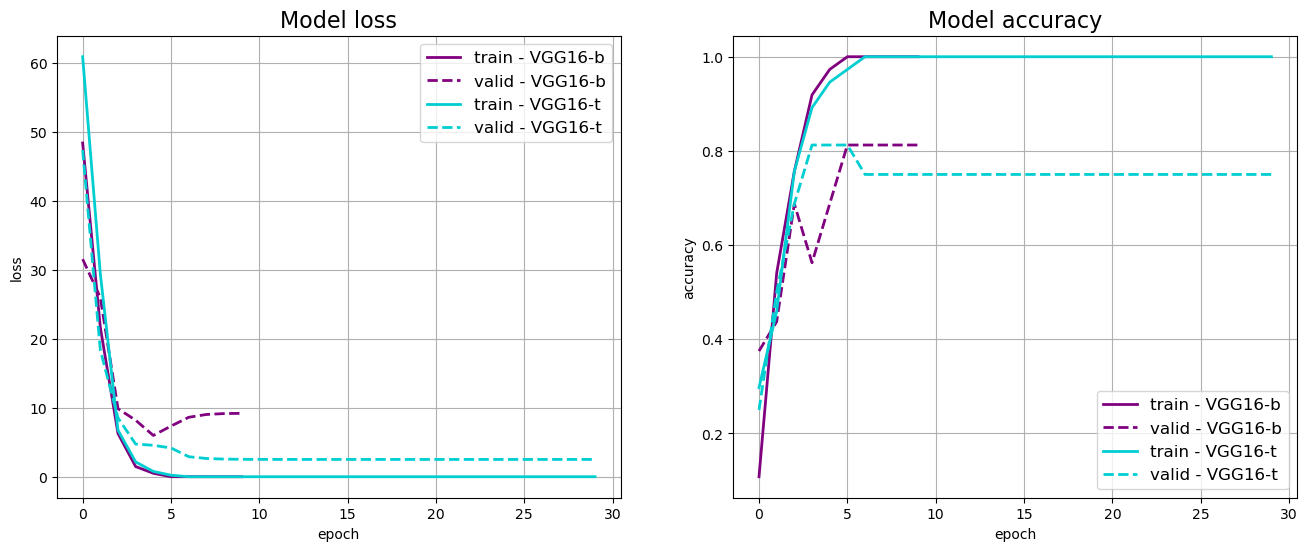

In [13]:
# Plots for loss and acc
from turtle import color


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16_3.history['loss'], label='train - VGG16-b', color = 'purple', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16_3.history['val_loss'], label='valid - VGG16-b', color = 'purple', linestyle='--',
        linewidth=2)
plt.plot(history_vgg16_4.history['loss'], label='train - VGG16-t', color = 'darkturquoise', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16_4.history['val_loss'], label='valid - VGG16-t', color = 'darkturquoise', linestyle='--',
        linewidth=2)
plt.title('Model loss', fontdict={'size': 16})  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(history_vgg16_3.history['accuracy'], label='train - VGG16-b', color = 'purple', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16_3.history['val_accuracy'], label='valid - VGG16-b', color = 'purple', linestyle='--',
        linewidth=2)
plt.plot(history_vgg16_4.history['accuracy'], label='train - VGG16-t', color = 'darkturquoise', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16_4.history['val_accuracy'], label='valid - VGG16-t', color = 'darkturquoise', linestyle='--',
        linewidth=2)
plt.title('Model accuracy',fontdict={'size': 16})  
plt.ylabel('accuracy')  
plt.xlabel('epoch') 
plt.grid()
plt.legend(fontsize=12)

Seems that the blank model performs better than the one with the pre-trained weigths.

In [15]:
# Evaluate the models
print("***Evaluation of the VGG16 with random weights")
model_vgg16_3.evaluate(test_batches, verbose=2)
print("***Evaluation of the VGG16 with pre-trained weights")
model_vgg16_4.evaluate(test_batches, verbose=2)

***Evaluation of the VGG16 with random weights
3/3 - 0s - loss: 4.7621 - accuracy: 0.9000 - 246ms/epoch - 82ms/step
***Evaluation of the VGG16 with pre-trained weights
3/3 - 0s - loss: 4.0472 - accuracy: 0.8000 - 217ms/epoch - 72ms/step


[4.047152042388916, 0.800000011920929]